In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import numpy as np

df = pd.read_csv("../data/lightcurves/P1.4736842105263157_R1.92_1411.8866757062847.csv")
time, flux, error = df.values.T
time -= time[0]

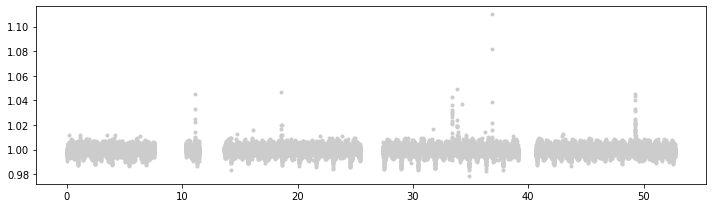

In [2]:
plt.figure(None, (10, 3))
plt.plot(time, flux, ".", c="0.8")
plt.tight_layout()

# Design matrix

In [3]:
X = time**np.arange(0, 3)[:, None]
X[1::] -= X[1::].mean(1)[:, None]
X[1::] /= X[1::].std(1)[:, None]

# GP optimisation

In [4]:
from nuance import Nuance
from tinygp import kernels, GaussianProcess

nu = Nuance(time, flux, np.mean(error), X, compute=False)

/Users/lgrcia/code/nuance/nuance/nuance.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
from nuance.nuance import *

def gp_optimization(self, build_gp, mask=None):
    if mask is None:
        mask = mask = np.ones_like(self.x).astype(bool)

    masked_x = self.x[mask]
    masked_y = self.y[mask]
    masked_X = self.X[:, mask]

    @jax.jit
    def nll_w(params):
        gp = build_gp(params, masked_x)
        Liy = gp.solver.solve_triangular(masked_y)
        LiX = gp.solver.solve_triangular(masked_X.T)
        LiXT = LiX.T
        LiX2 = LiXT@LiX
        w = jnp.linalg.lstsq(LiX2, LiXT@Liy)[0]
        nll = - gp.log_probability(masked_y - w@masked_X)
        return nll, w

    @jax.jit
    def nll(params):
        return nll_w(params)[0]

    @jax.jit
    def mu(params):
        gp = build_gp(params, masked_x)
        _, w = nll_w(params)
        cond_gp = gp.condition(masked_y - w@masked_X, self.x).gp
        return cond_gp.loc + w@self.X

    def optimize(init_params, param_names=None):
        def inner(theta, *args, **kwargs):
            params = dict(init_params, **theta)
            return nll(params, *args, **kwargs)

        param_names = list(init_params.keys()) if param_names is None else param_names
        start = {k: init_params[k] for k in param_names}

        solver = jaxopt.ScipyMinimize(fun=inner)
        soln = solver.run(start)
        print(soln.state)

        return dict(init_params, **soln.params)

    return optimize, mu, nll

In [6]:
def build_gp(params, x):
    periodic = kernels.quasisep.SHO(
        omega=jnp.exp(params["log_omega"]), 
        quality=jnp.exp(params["log_quality"]), 
        sigma=jnp.exp(params["log_sigma"])
    )    
    return GaussianProcess(periodic, x, diag=jnp.exp(2 * params["log_jitter"]), mean=0.)

optimize, mu, nll = gp_optimization(nu, build_gp)

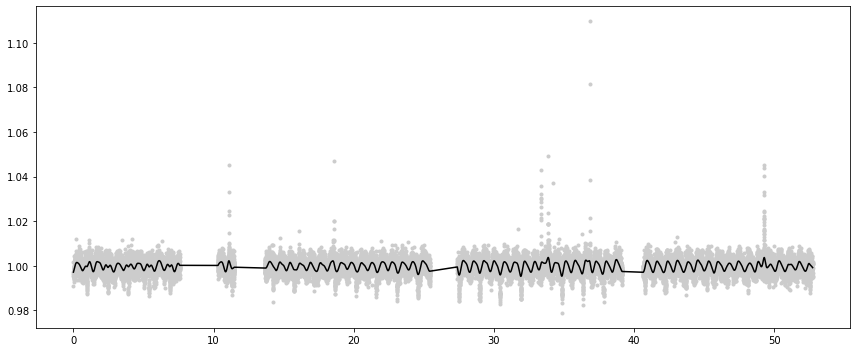

In [7]:
import jax.numpy as jnp

period = 17./24.

init_params = {
    "log_omega": jnp.log(2 * jnp.pi / period),
    "log_quality": jnp.log(50.),
    "log_sigma": jnp.log(np.std(flux)),
    "log_jitter": jnp.log(np.mean(error)),
}

plt.figure(None, (12, 5))
plt.plot(time, flux, ".", c="0.8")
plt.plot(time, mu(init_params), c="k")
plt.tight_layout()

DeviceArray(0.00298919, dtype=float32)

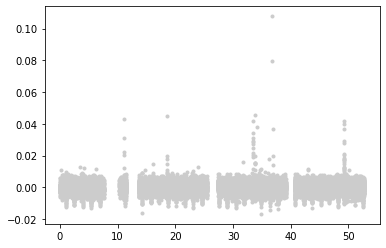

In [8]:
plt.plot(time, flux-mu(init_params), ".", c="0.8")
np.std(flux-mu(init_params))

In [9]:
plt.hist(flux-mu(init_params), bins=100)


KeyboardInterrupt



Error in callback <function flush_figures at 0x11f22ff40> (for post_execute):



KeyboardInterrupt



In [12]:
mask = np.ones_like(nu.x).astype(bool)
new_params = init_params.copy()
window = 30

for i in range(3):
    if i == 0:
        m = np.mean(flux)
    else:
        m = np.array(mu(new_params))
    r = (flux - m)
    mask_up = r < np.std(r[mask])*3
    mask_down = r > - np.std(r[mask])*2

    # mask around flares
    ups = np.flatnonzero(~mask_up)
    if len(ups) > 0:
        mask_up[np.hstack([np.arange(max(u-window, 0), min(u+window, len(nu.x))) for u in ups])] = False
    mask = np.logical_and(mask_up, mask_down)

    optimize, mu, plot_kernel = nu.gp_optimization(build_gp, mask=mask)
    new_params = optimize(new_params, ["log_sigma", "log_jitter"])
    new_params = optimize(new_params, ["log_quality", "log_sigma", "log_jitter"])
    new_params = optimize(new_params)

ScipyMinimizeInfo(fun_val=DeviceArray(-134735.28, dtype=float32, weak_type=True), success=False, status=2, iter_num=7)
ScipyMinimizeInfo(fun_val=DeviceArray(-134735.28, dtype=float32, weak_type=True), success=False, status=2, iter_num=0)
ScipyMinimizeInfo(fun_val=DeviceArray(-134861.33, dtype=float32, weak_type=True), success=False, status=2, iter_num=10)
ScipyMinimizeInfo(fun_val=DeviceArray(-117918.2, dtype=float32, weak_type=True), success=False, status=2, iter_num=7)
ScipyMinimizeInfo(fun_val=DeviceArray(-117921.63, dtype=float32, weak_type=True), success=False, status=2, iter_num=3)
ScipyMinimizeInfo(fun_val=DeviceArray(-117926.39, dtype=float32, weak_type=True), success=False, status=2, iter_num=6)
ScipyMinimizeInfo(fun_val=DeviceArray(-113370.195, dtype=float32, weak_type=True), success=False, status=2, iter_num=6)
ScipyMinimizeInfo(fun_val=DeviceArray(-113370.27, dtype=float32, weak_type=True), success=False, status=2, iter_num=2)
ScipyMinimizeInfo(fun_val=DeviceArray(-113370.3

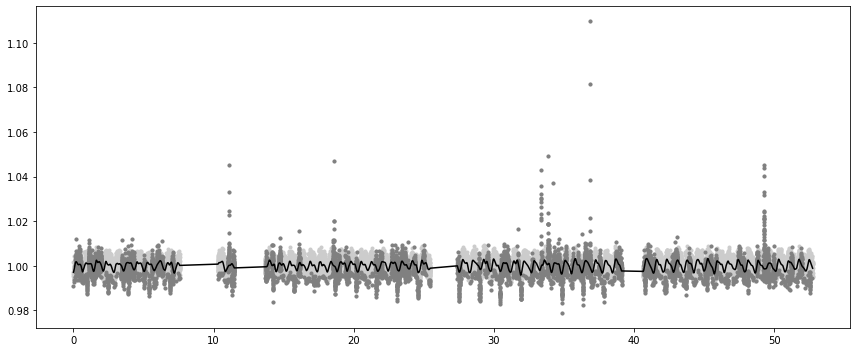

In [13]:
plt.figure(None, (12, 5))
plt.plot(time, flux, ".", c="0.8")
plt.plot(time[~mask], flux[~mask], ".", c="0.5")
plt.plot(time, mu(new_params), c="k")
plt.tight_layout()

# save

In [14]:
import yaml

final_params = {
    "omega": float(np.exp(new_params["log_omega"])),
    "quality": float(np.exp(new_params["log_quality"])),
    "jitter": float(np.exp(new_params["log_jitter"])),
    "sigma": float(np.exp(new_params["log_sigma"]))
}

yaml.safe_dump(final_params, open("../data/gp.yaml", "w"))